In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime as ort

Age Detection: https://www.thepythoncode.com/article/predict-age-using-opencv  
Gender Detection: https://www.thepythoncode.com/article/gender-detection-using-opencv-in-python

## Gender, Age, and Face Models 

In [2]:
# The gender model architecture
GENDER_MODEL = 'weights/deploy_gender.prototxt'

# The gender model pre-trained weights
GENDER_PROTO = 'weights/gender_net.caffemodel'

# Each Caffe Model impose the shape of the input image also image preprocessing is required like mean
# substraction to eliminate the effect of illumination changes
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

# Represent the gender classes
GENDER_LIST = ['Male', 'Female']

FACE_PROTO = "weights/deploy.prototxt.txt"

FACE_MODEL = "weights/res10_300x300_ssd_iter_140000_fp16.caffemodel"

AGE_PROTO = "weights/deploy_age.prototxt"

AGE_MODEL = "weights/age_net.caffemodel"

AGE_INTERVALS = ['(0, 2)', '(4, 6)', '(8, 12)', '(15, 20)',
                 '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']

frame_width = 1280
frame_height = 720

In [3]:
# load face Caffe model
face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)

# Load gender prediction model
gender_net = cv2.dnn.readNetFromCaffe(GENDER_MODEL, GENDER_PROTO)

# Load Age Prediction Model
age_net = cv2.dnn.readNetFromCaffe(AGE_PROTO, AGE_MODEL)

## Emotion Models 

https://github.com/onnx/models/tree/main/vision/body_analysis/emotion_ferplus  
https://github.com/onnx/models/blob/main/vision/classification/onnxrt_inference.ipynb

In [4]:
emotion_table = ['neutral', 
                 'happiness', 
                 'surprise', 
                 'sadness', 
                 'anger', 
                 'disgust', 
                 'fear', 
                 'contempt']

In [5]:
model_path = 'emotion_ferplus/model.onnx'
emotion_model = onnx.load(model_path)
session = ort.InferenceSession(emotion_model.SerializeToString())

In [6]:
def preprocess_emotion(img):
    input_shape = (1, 1, 64, 64)
    img_data = np.array(img)
    img_data = np.resize(img_data, input_shape)
    return img_data

In [7]:
def softmax(x):
    max = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - max) #subtracts each row with its max value
    sum = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sum 
    return f_x

In [8]:
def predict_emotion(img):
    img = preprocess_emotion(img)
    ort_inputs = {session.get_inputs()[0].name: img.astype(np.float32)}
    preds = session.run(None, ort_inputs)[0]
    preds = softmax(preds)
    preds = np.squeeze(preds)
    a = np.argsort(preds)[::-1]
    #print('class=%s ; probability=%f' % (emotion_table[a[0]], preds[a[0]]))
    
    emotion=emotion_table[a[0]]
    return emotion, preds[a[0]]

## Helper Functions

In [9]:
def get_faces(frame, confidence_threshold=0.5):
    # convert the frame into a blob to be ready for NN input
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104, 177.0, 123.0))
    
    # set the image as input to the NN
    face_net.setInput(blob)
    
    # perform inference and get predictions
    output = np.squeeze(face_net.forward())

    # initialize the result list
    faces = []
    
    # Loop over the faces detected
    for i in range(output.shape[0]):
        confidence = output[i, 2]
        if confidence > confidence_threshold:
            box = output[i, 3:7] * \
                np.array([frame.shape[1], frame.shape[0],
                          frame.shape[1], frame.shape[0]])
            # convert to integers
            start_x, start_y, end_x, end_y = box.astype(int)
            # widen the box a little
            start_x, start_y, end_x, end_y = start_x - \
                10, start_y - 10, end_x + 10, end_y + 10
            start_x = 0 if start_x < 0 else start_x
            start_y = 0 if start_y < 0 else start_y
            end_x = 0 if end_x < 0 else end_x
            end_y = 0 if end_y < 0 else end_y
            # append to our list
            faces.append((start_x, start_y, end_x, end_y))
            
    return faces

In [10]:
def display_img(title, img):
    """Displays an image on screen and maintains the output until the user presses a key"""
    # Display Image on screen
    plt.figure(figsize=(20,20))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

In [11]:
def get_optimal_font_scale(text, width):
    """Determine the optimal font scale based on the hosting frame width"""
    for scale in reversed(range(0, 60, 1)):
        textSize = cv2.getTextSize(
            text, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=scale/10, thickness=1)
        new_width = textSize[0][0]
        if (new_width <= width):
            return scale/10
    return 1


def image_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]
    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image
    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))
    # resize the image
    return cv2.resize(image, dim, interpolation=inter)

In [12]:
def predict_age_gender_emotion_utility(img):
    
    # Take a copy of the initial image and resize it
    frame = img.copy()
    if frame.shape[1] > frame_width:
        frame = image_resize(frame, width=frame_width)

    people = []
    # predict the faces
    faces = get_faces(frame)
    
    for i, (start_x, start_y, end_x, end_y) in enumerate(faces):
        face_img = frame[start_y: end_y, start_x: end_x]
        # image        = Input image to preprocess before passing it through our dnn for classification.
        # scale factor = After performing mean substraction we can optionally scale the image by some factor.
        #                (if 1 -> no scaling)
        # size         = The spatial size that the CNN expects. Options are = (224*224, 227*227 or 299*299)
        # mean         = mean substraction values to be substracted from every channel of the image.
        # swapRB       = OpenCV assumes images in BGR whereas the mean is supplied in RGB.
        #                To resolve this we set swapRB to True.
        blob = cv2.dnn.blobFromImage(image=face_img,
                                     scalefactor=1.0,
                                     size=(227, 227),
                                     mean=MODEL_MEAN_VALUES,
                                     swapRB=False,
                                     crop=False)

        
        # Predict Gender ###################
        gender_net.setInput(blob)
        gender_preds = gender_net.forward()

        i = gender_preds[0].argmax()
        gender = GENDER_LIST[i]
        gender_confidence_score = gender_preds[0][i]
         
        # Predict Age ######################
        age_net.setInput(blob)
        age_preds = age_net.forward()
        
        i = age_preds[0].argmax()
        age = AGE_INTERVALS[i]
        age_confidence_score = age_preds[0][i]
        
        # Predict Emotion ##################
        # Emotion model requires 64x64 image
        blob_64x64 = cv2.dnn.blobFromImage(image=face_img,
                                     scalefactor=1.0,
                                     size=(64, 64),
                                     mean=MODEL_MEAN_VALUES,
                                     swapRB=False,
                                     crop=False)
        
        emotion, emotion_probability = predict_emotion(blob_64x64)
        
        
        ####################################
        
        people.append({
            'gender'    : gender,
            'gender_confidence': gender_confidence_score,
            'age': age,
            'age_confidence': age_confidence_score,
            'emotion':emotion,
            'emotion_confidence':emotion_probability
        })
        
           
        # Plot Individual Faces
        """
        plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
        plt.title("%s - %s" %(gender, age))
        plt.show()
        """
        
        # Draw the box
        label = "{} - {} - {}".format(gender, age, emotion)

        yPos = start_y - 15
        while yPos < 15:
            yPos += 15
            
        # get the font scale for this image size
        optimal_font_scale = get_optimal_font_scale(label,
                                                    ((end_x-start_x)+25))
        box_color = (255, 0, 0) if gender == "Male" else (147, 20, 255)
        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), box_color, 2)

        # Label processed image
        cv2.putText(frame, label, (start_x, yPos),
                    cv2.FONT_HERSHEY_SIMPLEX, optimal_font_scale, box_color, 2)

    return frame, people    

In [13]:
def predict_age_gender_emotion(input_path: str):
        # Read Input Image
    img = cv2.imread(input_path)
    # resize the image, uncomment if you want to resize the image
    img = cv2.resize(img, (frame_width, frame_height))
    
    frame, people = predict_age_gender_emotion_utility(img)
    # Display processed image
    display_img("Estimator", frame)
    
    for person in people:
        for key in person:
            print(key, person[key])
        print()
    plt.show()
    plt.close("all")
    

In [14]:
def predict_age_gender_emotion_live():
    """Predict the gender of the faces showing in the image"""

    # create a new cam object
    cap = cv2.VideoCapture(0)

    genders = [0, 0]
    age_dict = {
        '(0, 2)': 0,
        '(4, 6)': 0,
        '(8, 12)': 0,
        '(15, 20)': 0,
        '(25, 32)': 0,
        '(38, 43)': 0,
        '(48, 53)': 0,
        '(60, 100)': 0}
    
    while True:
        _, img = cap.read()
        frame, people = predict_age_gender_emotion_utility(img)
        cv2.imshow("Gender Estimator", frame)

        # Log Age Prediction
        if people:
            age_dict[people[0]['age']] += 1

            # Break After n frames of consecutive gender
            min_frames = 25
            if people[0]['gender'] == 'Male':
                if genders[1] > 0:
                    genders = [0, 0]
                genders[0] += 1
            else:
                if genders[0] > 0:
                    genders = [0, 0]
                genders[1] += 1

            if genders[0] >= min_frames or genders[1] >= min_frames:
                if(genders[0] > 0):
                    print(GENDER_LIST[0])
                else:
                    print(GENDER_LIST[1])

                age_mode_key = max(age_dict, key=age_dict.get)
                print("Age: %s\tCount: %d" %
                      (age_mode_key, age_dict[age_mode_key]))
                print(people[0]['emotion'])
                break

        ##########################

        if cv2.waitKey(1) == ord("q"):
            break

        #print(people, end='\r')

    # Cleanup
    cv2.destroyAllWindows()

## Testing 

In [15]:
""" Uncomment line below to access your personal webcam. """
#predict_age_gender_emotion_live()

' Uncomment line below to access your personal webcam. '

gender Female
gender_confidence 0.99509996
age (25, 32)
age_confidence 0.97204214
emotion anger
emotion_confidence 0.9833935



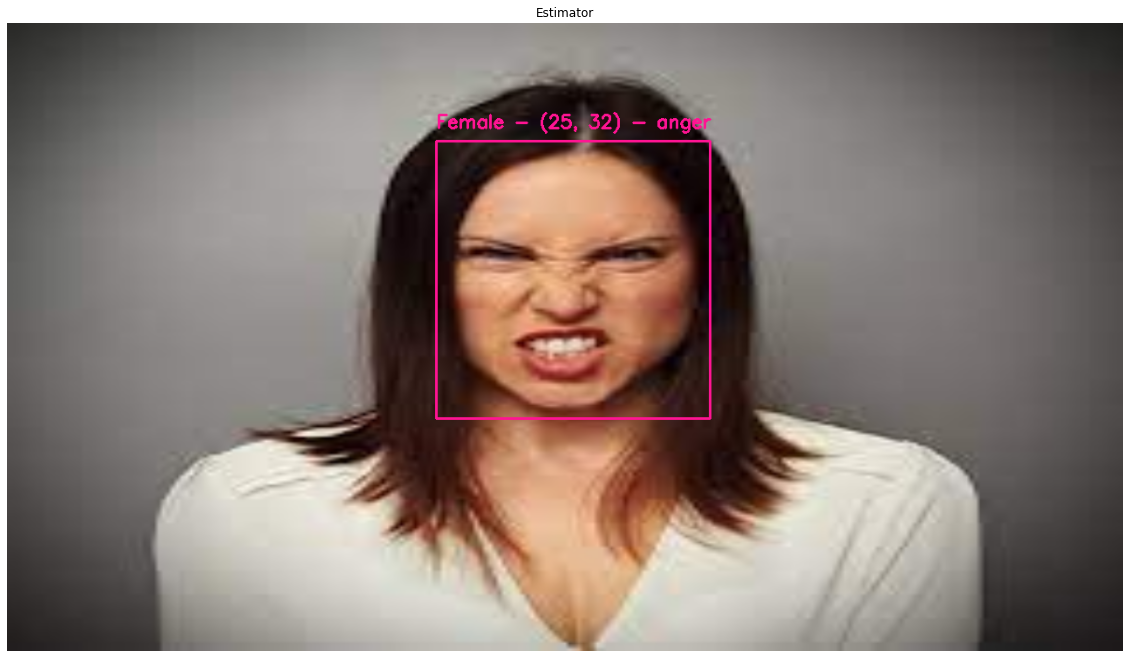

In [16]:
predict_age_gender_emotion('image/angry.jpeg')

gender Female
gender_confidence 0.999321
age (25, 32)
age_confidence 0.79366857
emotion anger
emotion_confidence 0.7608409



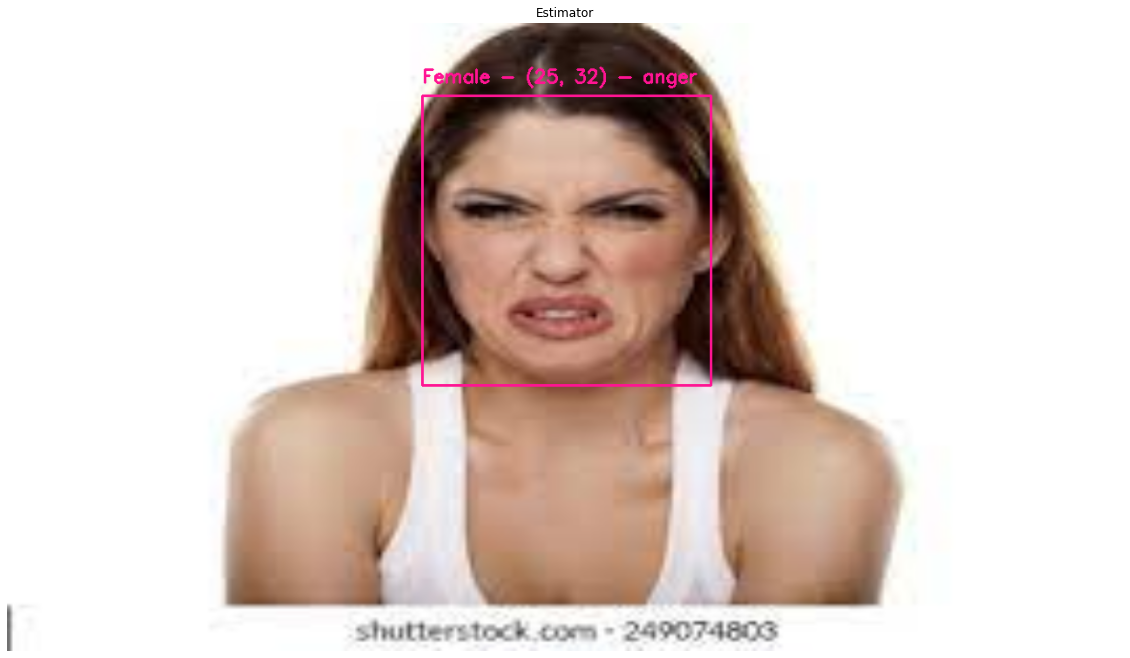

In [17]:
predict_age_gender_emotion('image/disgust.jpeg')

gender Male
gender_confidence 0.99996996
age (38, 43)
age_confidence 0.85363483
emotion fear
emotion_confidence 0.4588804



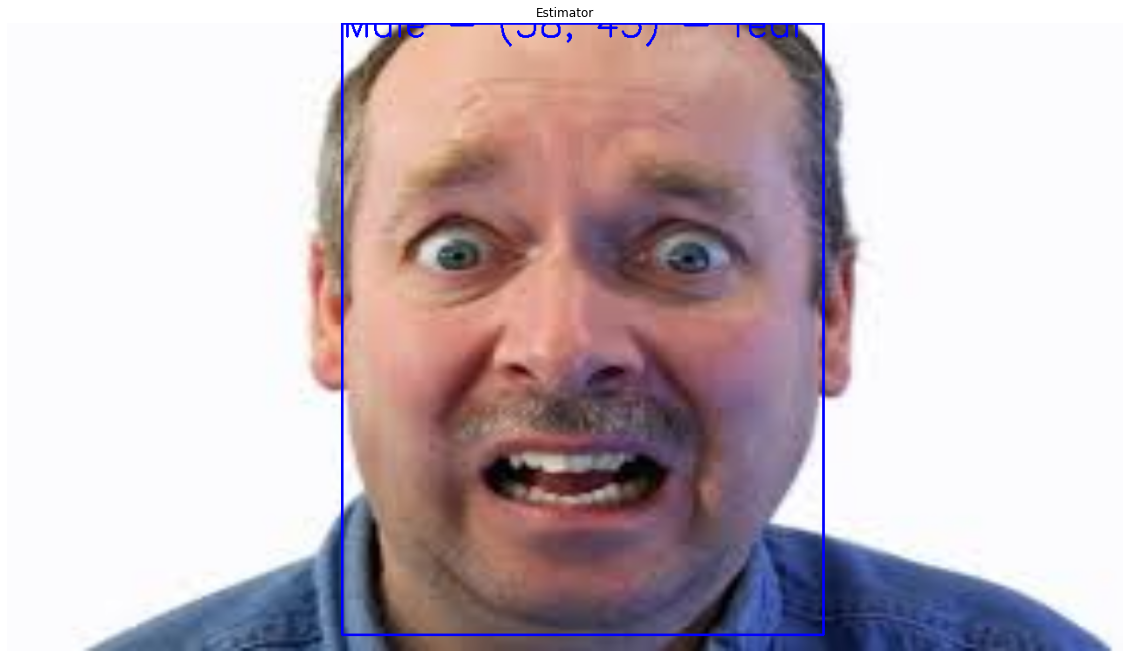

In [18]:
predict_age_gender_emotion('image/fear.jpeg')

gender Male
gender_confidence 0.996986
age (0, 2)
age_confidence 0.3921384
emotion sadness
emotion_confidence 0.50833815



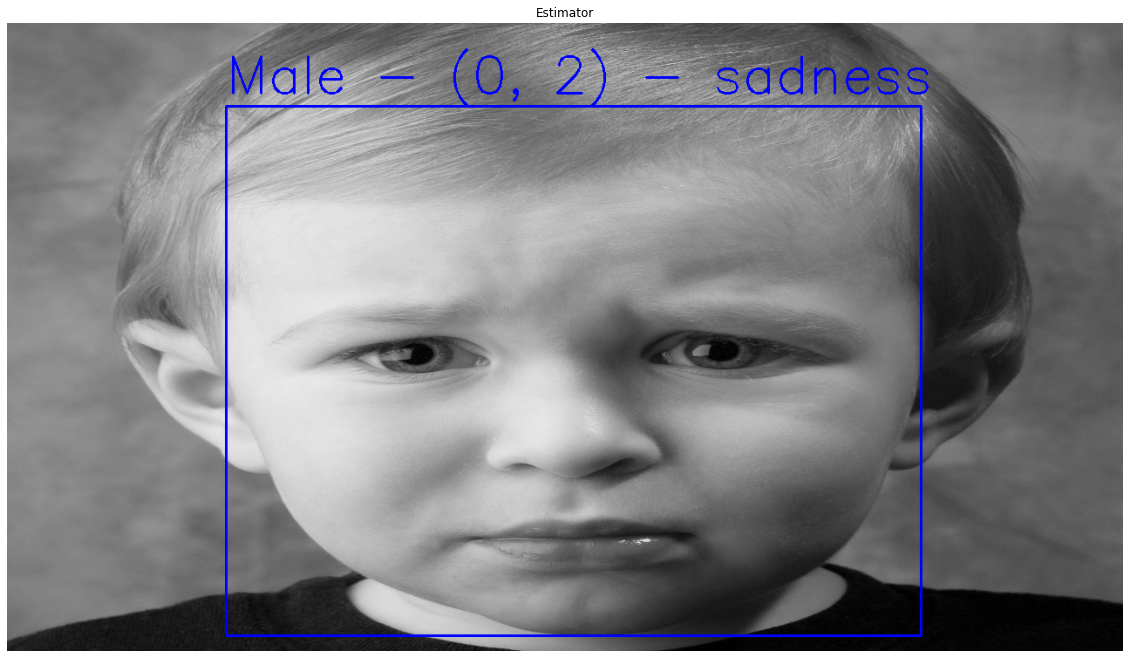

In [19]:
predict_age_gender_emotion('image/boy_sad.jpeg')

gender Female
gender_confidence 0.99988306
age (8, 12)
age_confidence 0.98000324
emotion happiness
emotion_confidence 0.9999727

gender Male
gender_confidence 0.9999628
age (25, 32)
age_confidence 0.9969771
emotion happiness
emotion_confidence 0.9997086

gender Male
gender_confidence 0.99996376
age (25, 32)
age_confidence 0.93180346
emotion happiness
emotion_confidence 0.9999858

gender Male
gender_confidence 0.9848577
age (25, 32)
age_confidence 0.9891606
emotion happiness
emotion_confidence 0.99990094

gender Female
gender_confidence 0.9994711
age (25, 32)
age_confidence 0.9717638
emotion happiness
emotion_confidence 0.9999653

gender Female
gender_confidence 0.7254157
age (15, 20)
age_confidence 0.60913503
emotion happiness
emotion_confidence 0.99999344

gender Male
gender_confidence 0.76329666
age (38, 43)
age_confidence 0.52659464
emotion happiness
emotion_confidence 0.99995387

gender Female
gender_confidence 0.9978211
age (25, 32)
age_confidence 0.44876182
emotion happiness
emot

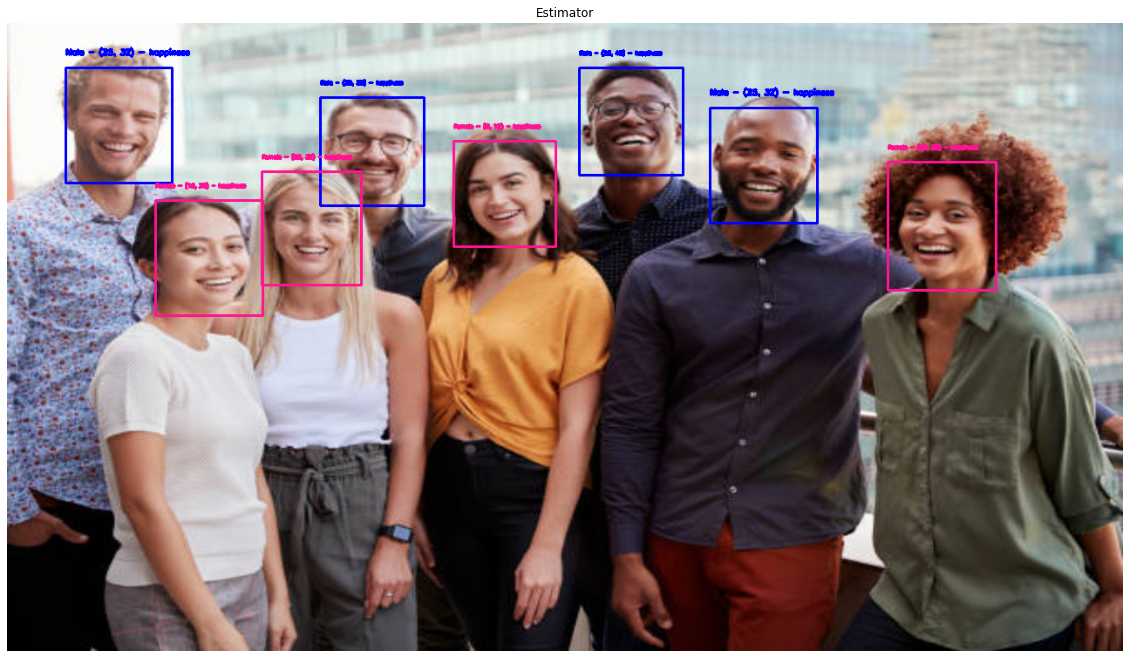

In [20]:
predict_age_gender_emotion('image/group.jpg')